In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
#Columns in each table

inspector = inspect(engine)

columns = inspector.get_columns('measurement')
print("Measurement")
for c in columns:
    print(c['name'], c["type"])
    
columns = inspector.get_columns('station')
print("\nStations")
for c in columns:
    print(c['name'], c["type"])

Measurement
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Stations
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(measurement.date).order_by((measurement.date).desc()).first()
last_date
print(f"The last date is {last_date[0]}")

last_year_date = (dt.datetime.strptime(last_date[0],'%Y-%m-%d') - dt.timedelta(days=365)).strftime('%Y-%m-%d')
last_year_date

print(f"The date one year ago is {last_year_date}")

The last date is 2017-08-23
The date one year ago is 2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= last_year_date).all()

precipitation_data[:10]

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0)]

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column 
# Sort the dataframe by date

precipitation_data_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation_Level'])\
                        .sort_values(['Date'])\
                        .dropna()
precipitation_data_df = precipitation_data_df.set_index('Date')
precipitation_data_df.head(10)


,Precipitation_Level
Date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70
2016-08-23,0.02
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28


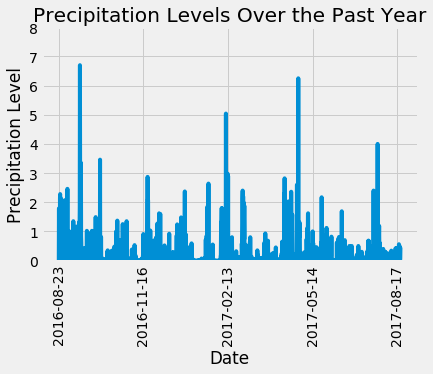

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
plot1 = precipitation_data_df.plot(rot=90);
plot1.set_title("Precipitation Levels Over the Past Year")
plot1.set_ylabel("Precipitation Level")
plot1.set_ylim([0,8])
plot1.get_legend().remove()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data_df.describe()

,Precipitation_Level
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(station.id)).all()
station_count

[(9)]

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_station = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by((func.count(measurement.station).desc())).all()

active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)).\
filter(measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
USC00519281_temp_data = session.query(measurement.date, measurement.tobs).\
    filter(measurement.date >= last_year_date).\
    filter(measurement.station == 'USC00519281').all()

USC00519281_temp_data[:10]

[('2016-08-23', 77.0),
 ('2016-08-24', 77.0),
 ('2016-08-25', 80.0),
 ('2016-08-26', 80.0),
 ('2016-08-27', 75.0),
 ('2016-08-28', 73.0),
 ('2016-08-29', 78.0),
 ('2016-08-30', 77.0),
 ('2016-08-31', 78.0),
 ('2016-09-01', 80.0)]

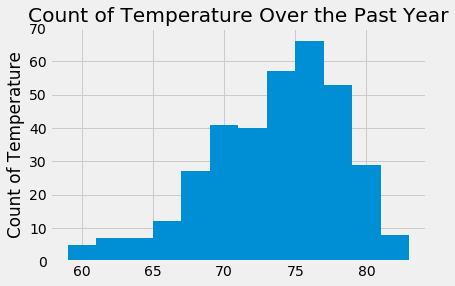

In [21]:
#Plot the results as a histogram
USC00519281_df = pd.DataFrame(USC00519281_temp_data, columns=['Date', 'Temperature'])\
                    .sort_values(['Date'])\
                    .dropna()
plot2 = USC00519281_df.plot(kind="hist",bins=12)
plot2.set_title("Count of Temperature Over the Past Year")
plot2.set_ylabel("Count of Temperature")
plot2.set_ylim([0,70])
plot2.get_legend().remove()